In [2]:
from qutip import *
from qutip.piqs import *
import numpy as np
import math
import matplotlib.pyplot as plt
import random

np.set_printoptions(threshold=np.inf)
qutip.about()


QuTiP: Quantum Toolbox in Python
Copyright (c) QuTiP team 2011 and later.
Current admin team: Alexander Pitchford, Nathan Shammah, Shahnawaz Ahmed, Neill Lambert, Eric Giguère, Boxi Li, Jake Lishman, Simon Cross, Asier Galicia, Paul Menczel, and Patrick Hopf.
Board members: Daniel Burgarth, Robert Johansson, Anton F. Kockum, Franco Nori and Will Zeng.
Original developers: R. J. Johansson & P. D. Nation.
Previous lead developers: Chris Granade & A. Grimsmo.
Currently developed through wide collaboration. See https://github.com/qutip for details.

QuTiP Version:      5.0.3.post1
Numpy Version:      2.0.1
Scipy Version:      1.14.0
Cython Version:     None
Matplotlib Version: 3.9.1
Python Version:     3.12.4
Number of CPUs:     24
BLAS Info:          Generic
INTEL MKL Ext:      False
Platform Info:      Linux (x86_64)
Installation path:  /home/harsh/anaconda3/envs/qiskit/lib/python3.12/site-packages/qutip
Please cite QuTiP in your publication.
For your convenience a bibtex reference can 

In [3]:
# Initial State
def State(N,J,M1,M2):
    st = (dicke(N,J,M1).eigenstates()[1][-1])# + dicke(N,J,M2).eigenstates()[1][-1])/np.sqrt(2)
    return(st)

In [4]:
# Coefficients of collapse operators in PI Basis
def bm(j,m):
    return (-np.sqrt((j+m)*(j+m-1)))

def dm(j,m):
    return (np.sqrt((j-m+1)*(j-m+1)))

def bp(j,m):
    return (np.sqrt((j-m)*(j-m-1)))

def dp(j,m):
    return (-np.sqrt((j+m+1)*(j+m+1)))

def cj(N,J):
    if J== N/2:
        return np.sqrt(1/(2*J))

    else:
        return np.sqrt((1/(2*(J)))*((N/2+1)/(J+1)))

def cjp1(N,J):
    return np.sqrt((1/(2*(J+1)))*((N/2-J)/(2*J+1)))

def cjm1(N,J):
    return np.sqrt((1/(2*(J)))*((N/2+J+1)/(2*J+1)))

In [5]:
# Collapse operators
def SmJ(N):
    sop = dicke_basis(N,{(N/2, N/2, N/2): 0})
    for j in range(N//2,0,-1):
        for m in range(j,-j,-1):
            bra = (dicke(N,j,m).eigenstates()[1][-1]).dag()
            ket = cj(N,j)*am(j,m)*(dicke(N,j,m-1).eigenstates()[1][-1])
            sop += (ket*bra)

    return(sop)

def SmJp1(N):
    sop = dicke_basis(N,{(N/2, N/2, N/2): 0})
    for j in range(N//2-1,-1,-1):
        for m in range(j,-j,-1):
            bra = (dicke(N,j,m).eigenstates()[1][-1]).dag()
            ket = cjp1(N,j)*dm(j,m)*(dicke(N,j+1,m-1).eigenstates()[1][-1])
            sop += (ket*bra)

    return(sop)

def SmJm1(N):
    sop = dicke_basis(N,{(N/2, N/2, N/2): 0})
    for j in range(N//2,0,-1):
        for m in range(j,-j,-1):
            if -j+1<m-1 and m-1<j-1:
                bra = (dicke(N,j,m).eigenstates()[1][-1]).dag()
                ket = cjm1(N,j)*bm(j,m)*(dicke(N,j-1,m-1).eigenstates()[1][-1])
                sop += (ket*bra)

    return(sop)

In [6]:
def decSt(state,N):
    dstvec = []
    dstnrm = []
    dstvec.append(SmJm1(N)*state)
    dstvec.append(SmJ(N)*state)
    dstvec.append(SmJp1(N)*state)
    dstnrm = [dstvec[i].norm()**2 for i in range(3)]
    for i in range(3):
        if dstnrm[i]:
            dstvec[i] /= dstvec[i].norm()
    
    return (np.array(dstvec),np.array(dstnrm))

In [7]:
## Effective Hamiltonian:
def Hamiltonians(Δ,γ,N=12):
    system = Dicke(N = N)
    [Jx, Jy, Jz] = jspin(N)
    
    He = Δ*Jz - (1j*γ/2)*(N/2+Jz)
    return He

## MC solver Harsh
def mcsolveH(H,ψ,t,dr,ϵ1,ϵ2,N,J,choice):
    st = []
    data = []
    [jx, jy, Jz] = jspin(N)
    Jp = jspin(N,'+')
    
    st.append(ψ)
    data.append(expect(Jz,ψ))
    st_d = ψ
    for i in range(1,len(t)):
        h = t[i]-t[i-1]
        
        dst, dstn= decSt(st[-1],N)
        dJ = [J-1,J,J+1]
        
        dp = np.sum(dstn)
        dP = np.cumsum(dstn)/dp
        
        if dr*h*dp < ϵ1[i] :
            st_d = (1-1j*h*H.dag())*st[-1]

        else:
            k = np.searchsorted(dP,ϵ2[i],side='left')
            st_d = dst[k]
            J = dJ[k]

            # Performing recovery
            #if choice:
            #    st_d = Jp*st_d#Recovery(st_d,N)
        st_d = Qobj(st_d)
        st_d = st_d/st_d.norm()
        st.append(st_d)
        data.append(expect(Jz,st_d))
    return data

In [8]:
N = 8; J = 4;
tmax = 1; delta = 0.1/tmax;
dr = 1                                   #decay rate

EncSt = State(N,J,J,-J+1)
Hwp = Hamiltonians(delta,dr,N)

h = 0.1/np.linalg.norm(Hwp, ord ='fro') # timestep
print('Time Step = ',h)

nmax = 100; npts = int(tmax/h);
print('No of data points = ',npts)
print('No of trajectories = ',nmax)

t = np.linspace(0,tmax,npts+1)
data = np.zeros((nmax,len(t)))

for ntraj in range(nmax):
    prob1 = np.random.uniform(0.0, 1.0, npts+1)    #Uniform random numbers
    prob2 = np.random.uniform(0.0, 1.0, npts+1)
    
    EncSt_wp = mcsolveH(Hwp,EncSt,t,dr,prob1,prob2,N,J,0)
    data[ntraj,:] = EncSt_wp

    if ntraj%1==0:
        print(f'Finished Calculations for {ntraj+1} trajectories.')

DataMcH = [np.average(data[:,j]) for j in range(len(t))]

NameError: name 'dicke' is not defined

In [8]:
system = Dicke(N = N)
[jx, jy, jz] = jspin(N)

system.hamiltonian = delta*jz                   #System Hamiltonian
system.emission = dr                            #Single Spin Decay Rate
D_tls = system.liouvillian()                    #Lindblad Master Equation   
result1 = mesolve(D_tls, EncSt, t, [], e_ops = [jz])
DataMeQ = result1.expect[0]

cops = []
jz = 0*tensor([qeye(2) for i in range(N)])
for i in range(N):
    op = [qeye(2) for j in range(N)]
    op1 = [qeye(2) for j in range(N)]
    op[i] = jmat(0.5,'-')
    op1[i] = jmat(0.5,'z')
    
    cops.append(np.sqrt(dr)*tensor(op))
    jz += tensor(op1)

st = tensor([basis(2,0) for i in range(N)])
result = mcsolve(delta*jz, st, t, cops, e_ops = [jz],ntraj=1000)
DataMcQ = result.expect[0]

10.0%. Run time:   0.19s. Est. time left: 00:00:00:01
20.0%. Run time:   0.30s. Est. time left: 00:00:00:01
30.0%. Run time:   0.41s. Est. time left: 00:00:00:00
40.0%. Run time:   0.53s. Est. time left: 00:00:00:00
50.0%. Run time:   0.64s. Est. time left: 00:00:00:00
60.0%. Run time:   0.75s. Est. time left: 00:00:00:00
70.0%. Run time:   0.87s. Est. time left: 00:00:00:00
80.0%. Run time:   0.99s. Est. time left: 00:00:00:00
90.0%. Run time:   1.10s. Est. time left: 00:00:00:00
100.0%. Run time:   1.21s. Est. time left: 00:00:00:00
Total run time:   1.22s


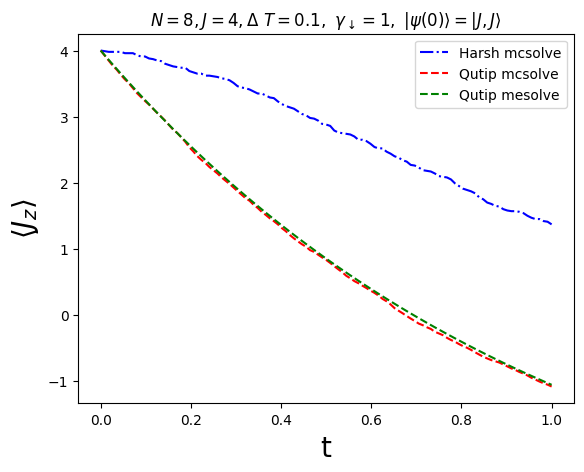

In [9]:
plt.plot(t,DataMcH,'b-.',label='Harsh mcsolve')
plt.plot(t,DataMcQ,'r--',label=r'Qutip mcsolve')
plt.plot(t,DataMeQ,'g--',label=r'Qutip mesolve')

plt.xlabel('t',fontsize=20,labelpad=5)
plt.ylabel(r'$\langle J_z \rangle$',fontsize=20,labelpad=5)
plt.legend()
#plt.ylim((0,0.1))
#plt.xlim((0,0.03))
plt.title(r'$N = 8, J = 4, \Delta ~T = 0.1, ~ \gamma_{\downarrow} = 1, ~ |\psi(0)\rangle = |J,J\rangle$ ')
plt.savefig(f"Check.png",bbox_inches='tight',dpi=400)

In [10]:
N = 4
(SmJ(N).dag()*SmJ(N)+SmJp1(N).dag()*SmJp1(N)+SmJm1(N).dag()*SmJm1(N))

Quantum object: dims = [[9], [9]], shape = (9, 9), type = oper, isherm = True
Qobj data =
[[1.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         3.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         1.5        0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         1.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         1.58333333
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  1.83333333 0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]]